In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15218, done.
remote: Total 15218 (delta 0), reused 0 (delta 0), pack-reused 15218
Receiving objects: 100% (15218/15218), 14.15 MiB | 34.26 MiB/s, done.
Resolving deltas: 100% (10436/10436), done.
/content/yolov5


In [ ]:
!pip install -qr requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.3.2 which is incompatible.


In [ ]:
import torch

from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.13.1+cu116 (NVIDIA A100-SXM4-40GB)


In [ ]:
%cd /content
!wget https://learnopencv.s3.us-west-2.amazonaws.com/pothole_dataset.zip
!unzip pothole_dataset.zip -d custom_dataset
!rm pothole_dataset.zip

/content
--2023-02-19 10:49:24--  https://learnopencv.s3.us-west-2.amazonaws.com/pothole_dataset.zip
Resolving learnopencv.s3.us-west-2.amazonaws.com (learnopencv.s3.us-west-2.amazonaws.com)... 52.218.137.177, 52.92.145.34, 3.5.79.119, ...
Connecting to learnopencv.s3.us-west-2.amazonaws.com (learnopencv.s3.us-west-2.amazonaws.com)|52.218.137.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439133609 (419M) [application/zip]
Saving to: ‘pothole_dataset.zip’

pothole_dataset.zip 100%[===================>] 418.79M  47.9MB/s    in 9.1s    

2023-02-19 10:49:33 (46.1 MB/s) - ‘pothole_dataset.zip’ saved [439133609/439133609]

Archive:  pothole_dataset.zip
   creating: custom_dataset/pothole_dataset/
   creating: custom_dataset/pothole_dataset/images/
   creating: custom_dataset/pothole_dataset/images/train/
  inflating: custom_dataset/pothole_dataset/images/train/img-111_jpg.rf.d7e58630e249c45d8c1d564d847dc236.jpg  
  inflating: custom_dataset/pothole_dataset/im

In [ ]:
# Create data.yaml file inside images folder 
# Path should look something like this: /content/custom_dataset/pothole_dataset/images/data.yaml
# Paste the following contents starting from train to names into the yaml file

'''
train: /content/custom_dataset/pothole_dataset/images/train
val: /content/custom_dataset/pothole_dataset/images/valid

nc: 1
names: ['pothole']
'''

In [ ]:
import yaml
with open("/content/custom_dataset/pothole_dataset/images/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5
!python train.py --img 640 --batch 16 --epochs 500 --data '/content/custom_dataset/pothole_dataset/images/data.yaml' --cfg /content/yolov5/models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
train: weights=, cfg=/content/yolov5/models/custom_yolov5s.yaml, data=/content/custom_dataset/pothole_dataset/images/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=500, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-107-g7a972e8 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05

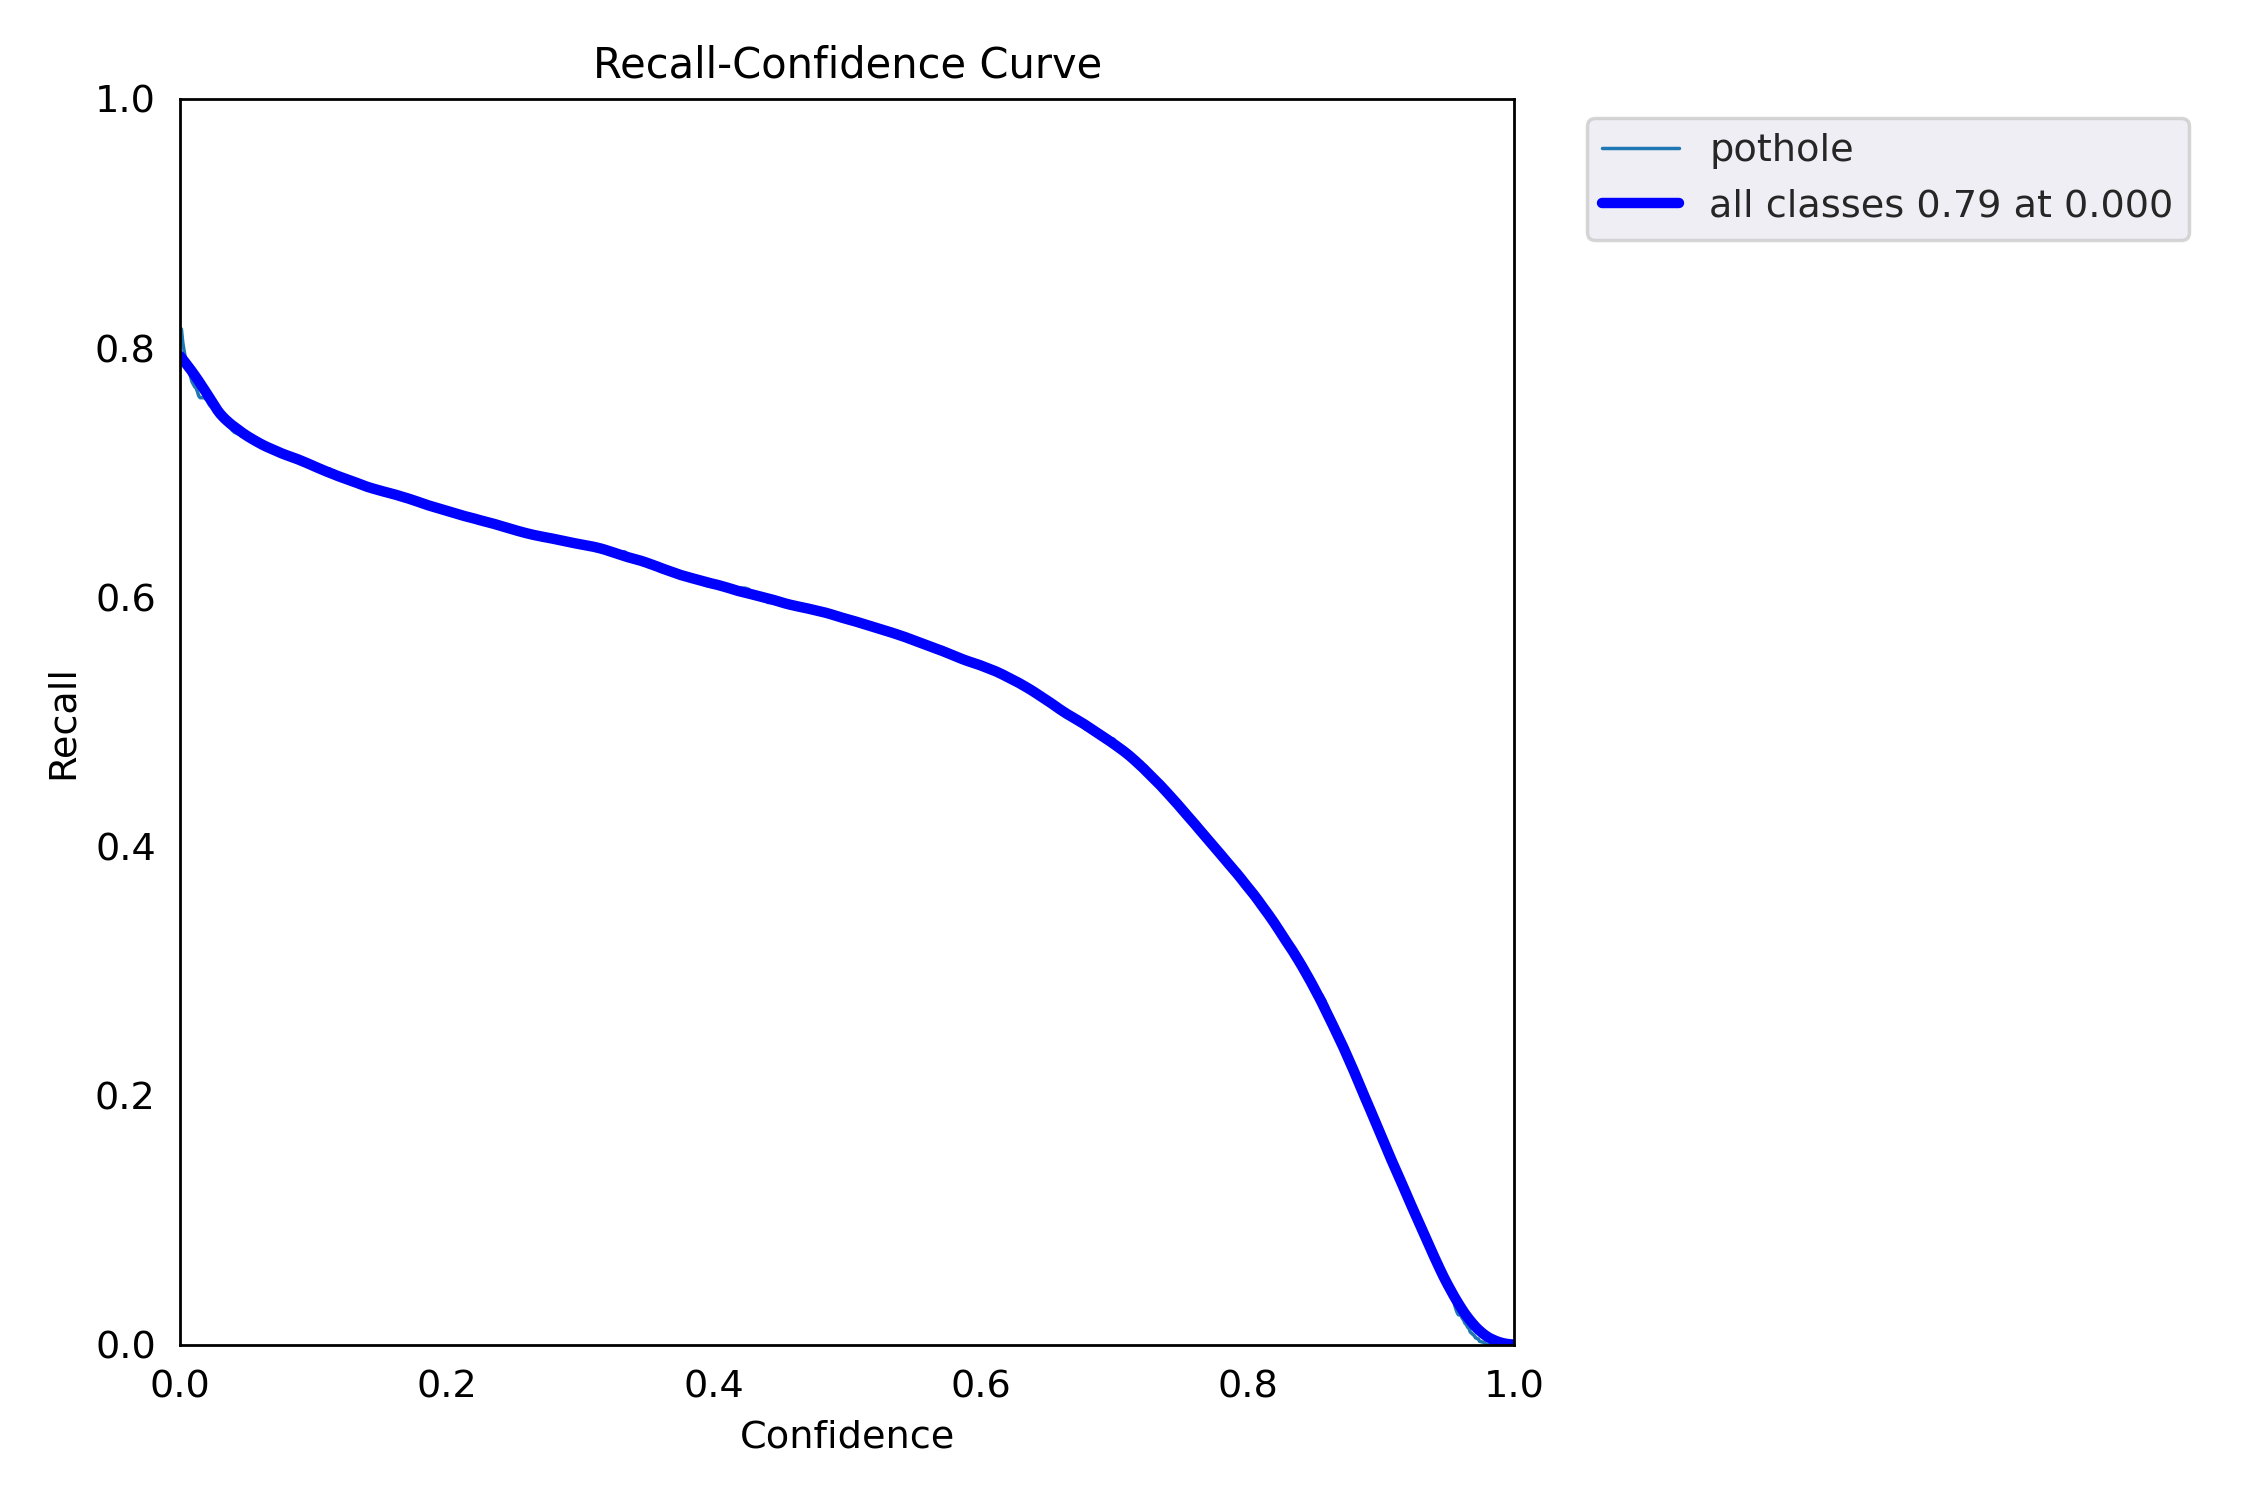

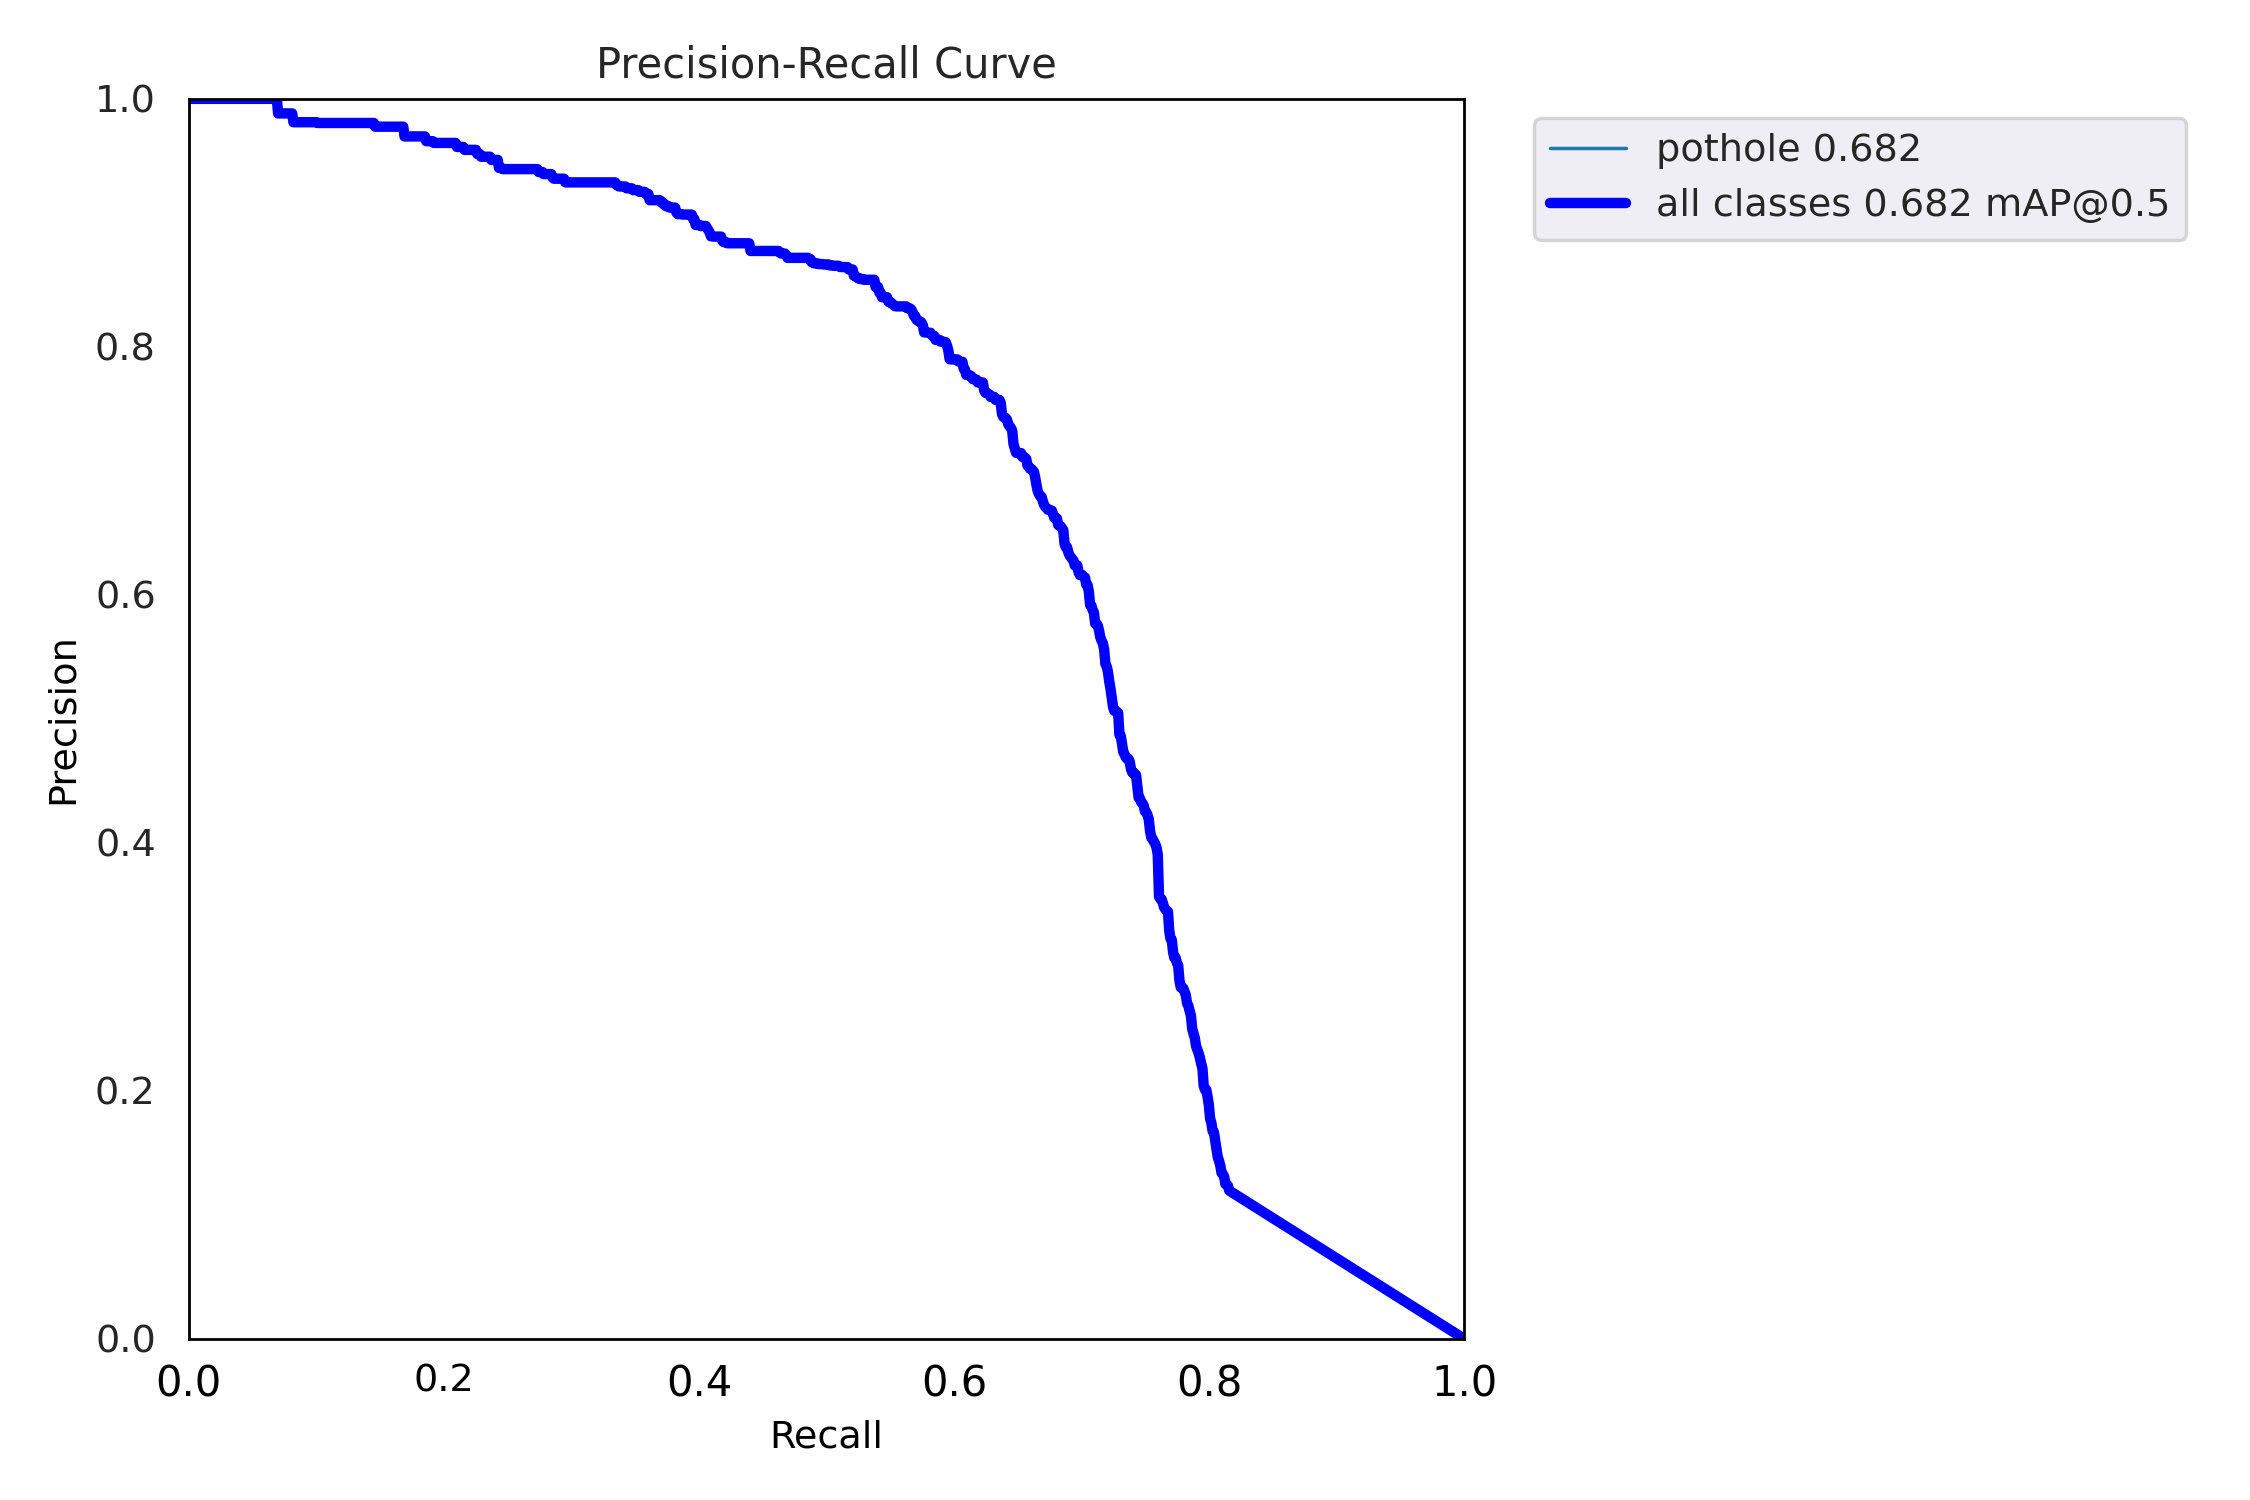

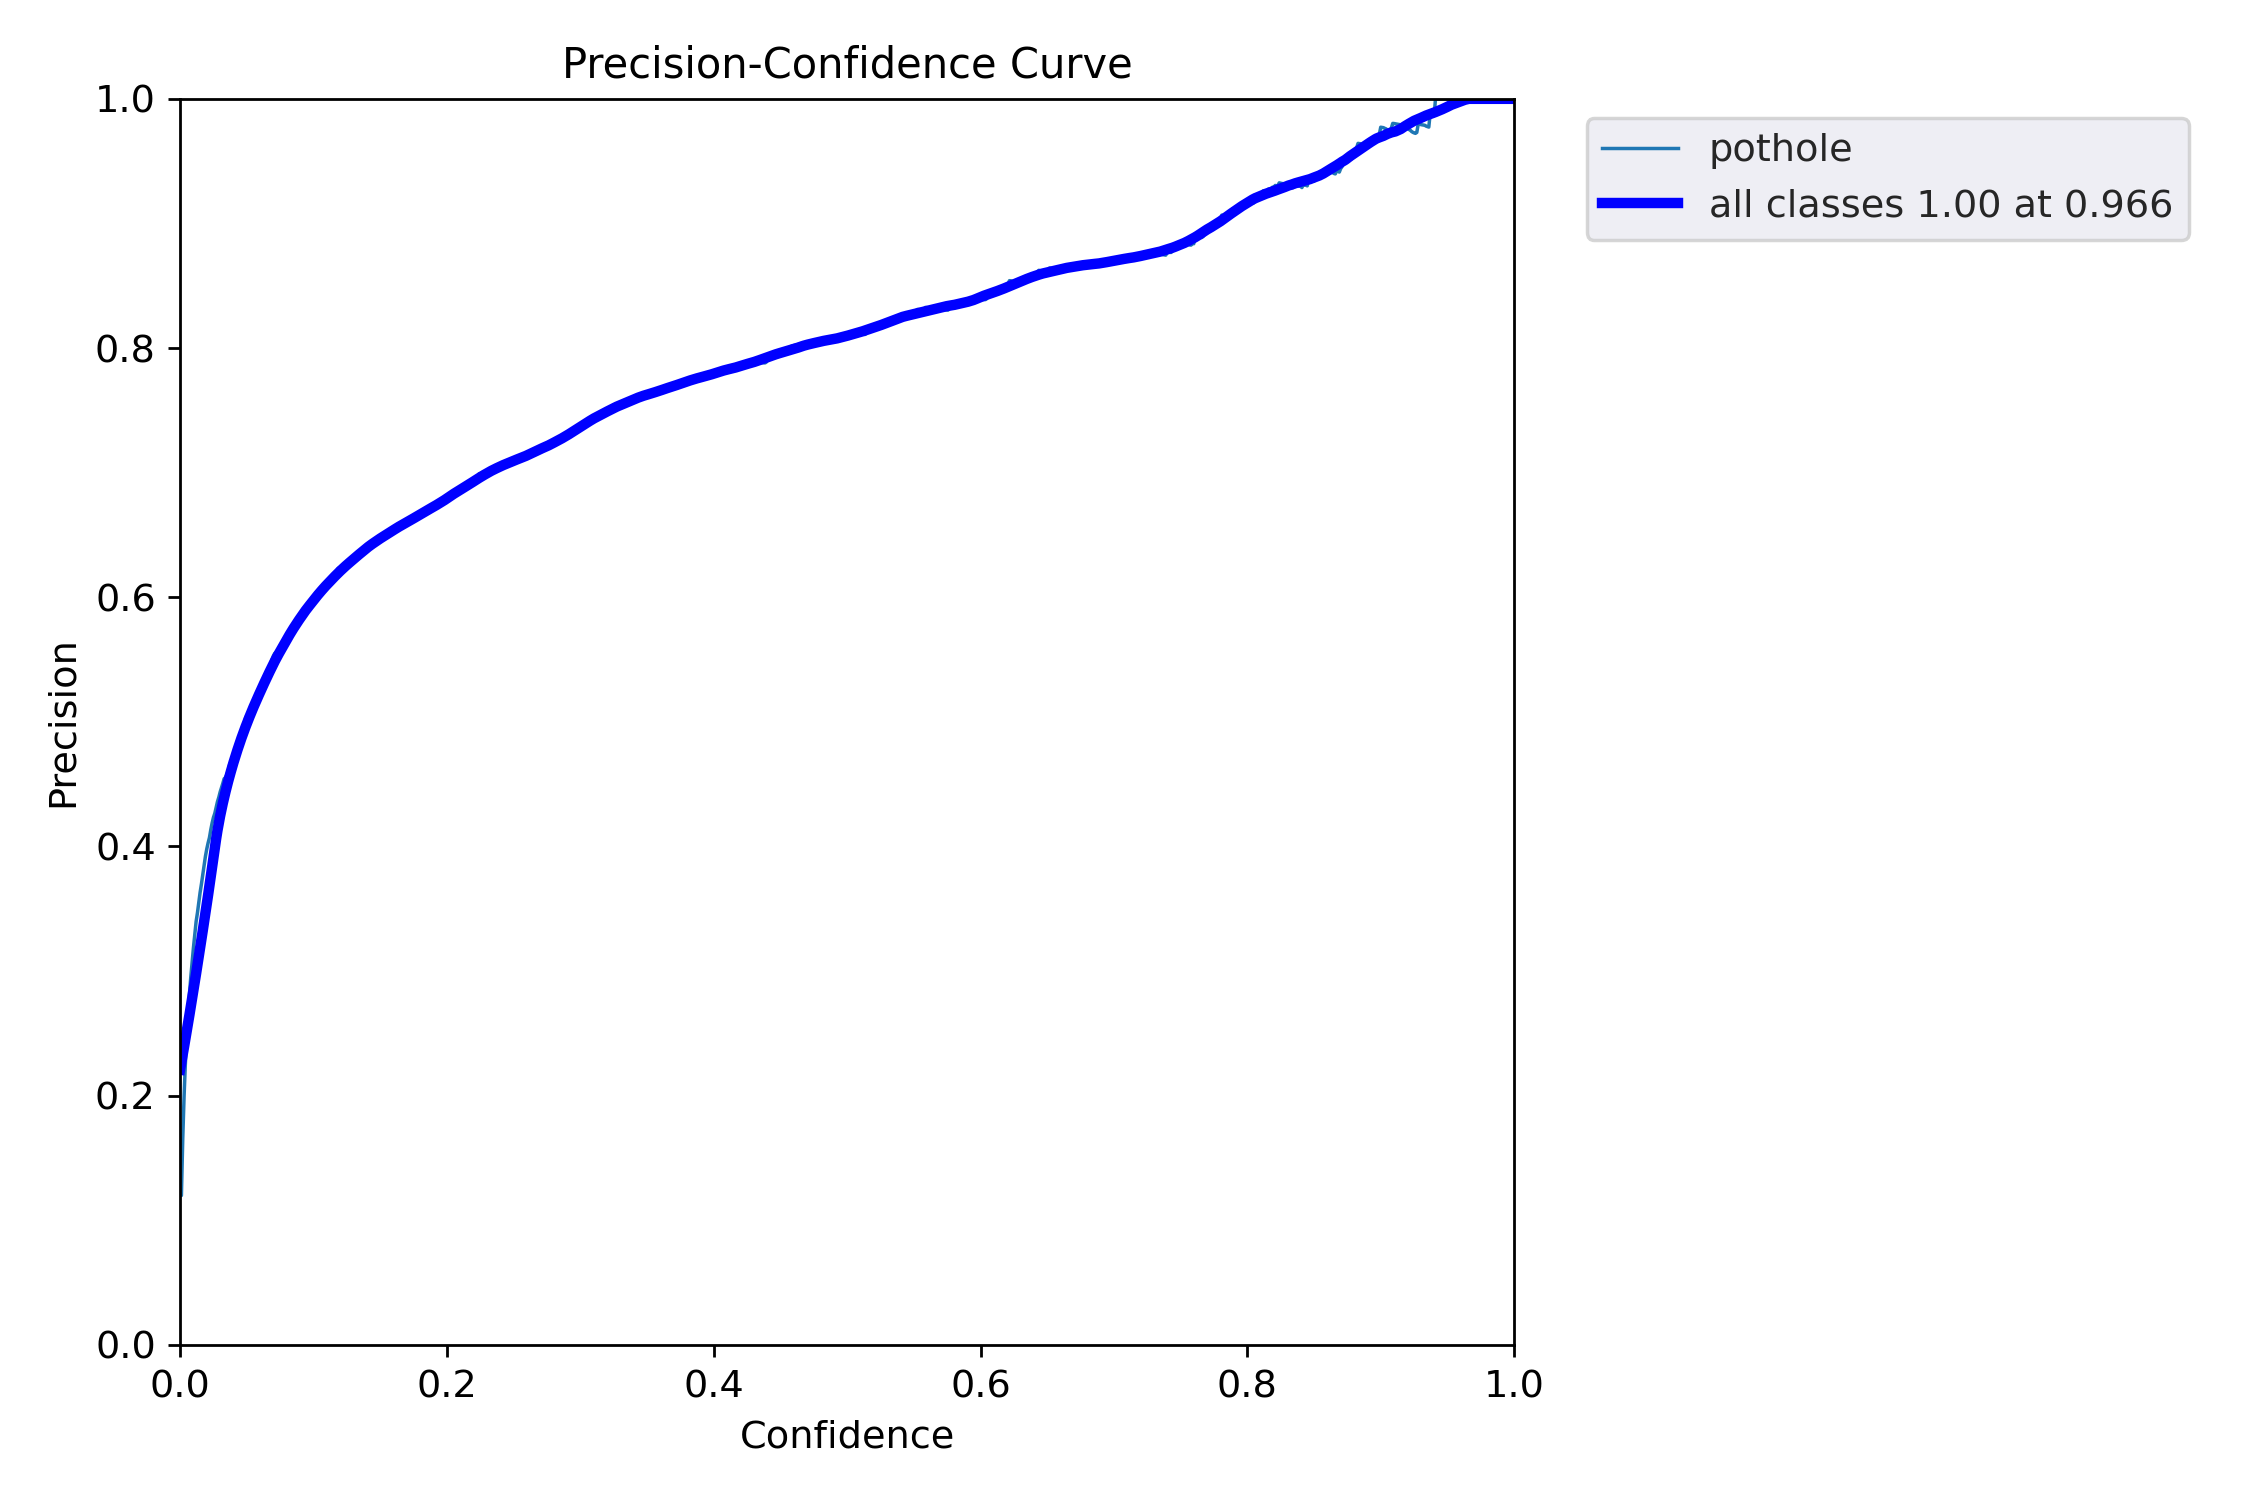

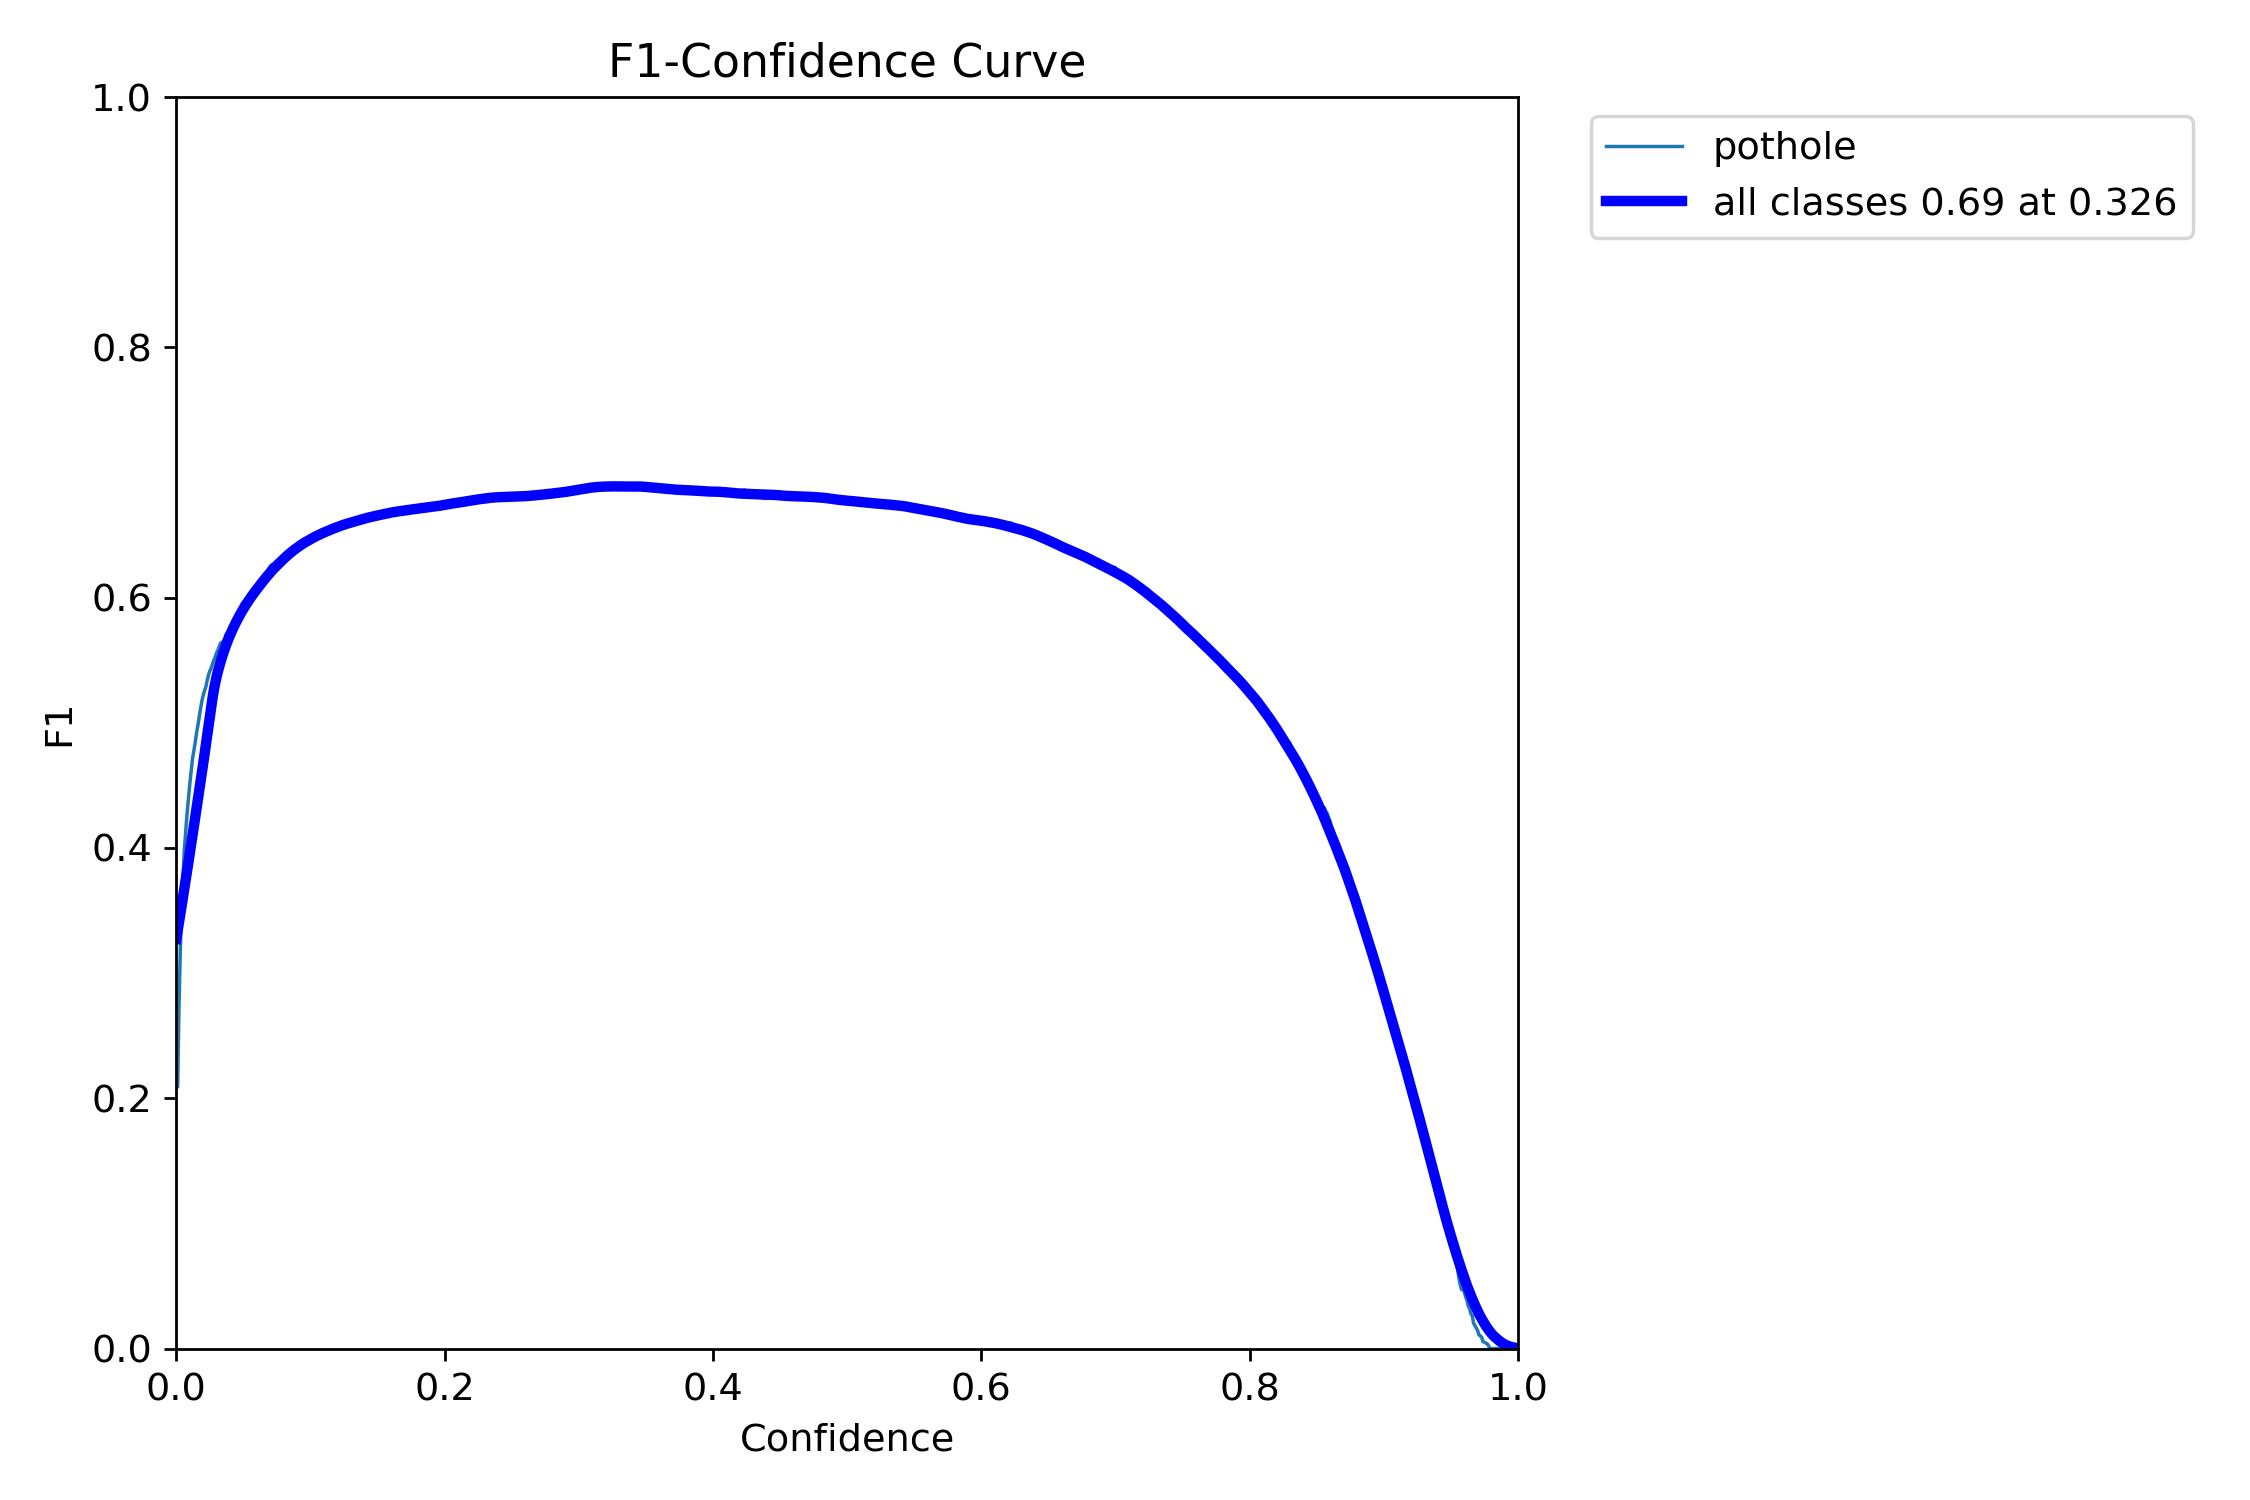

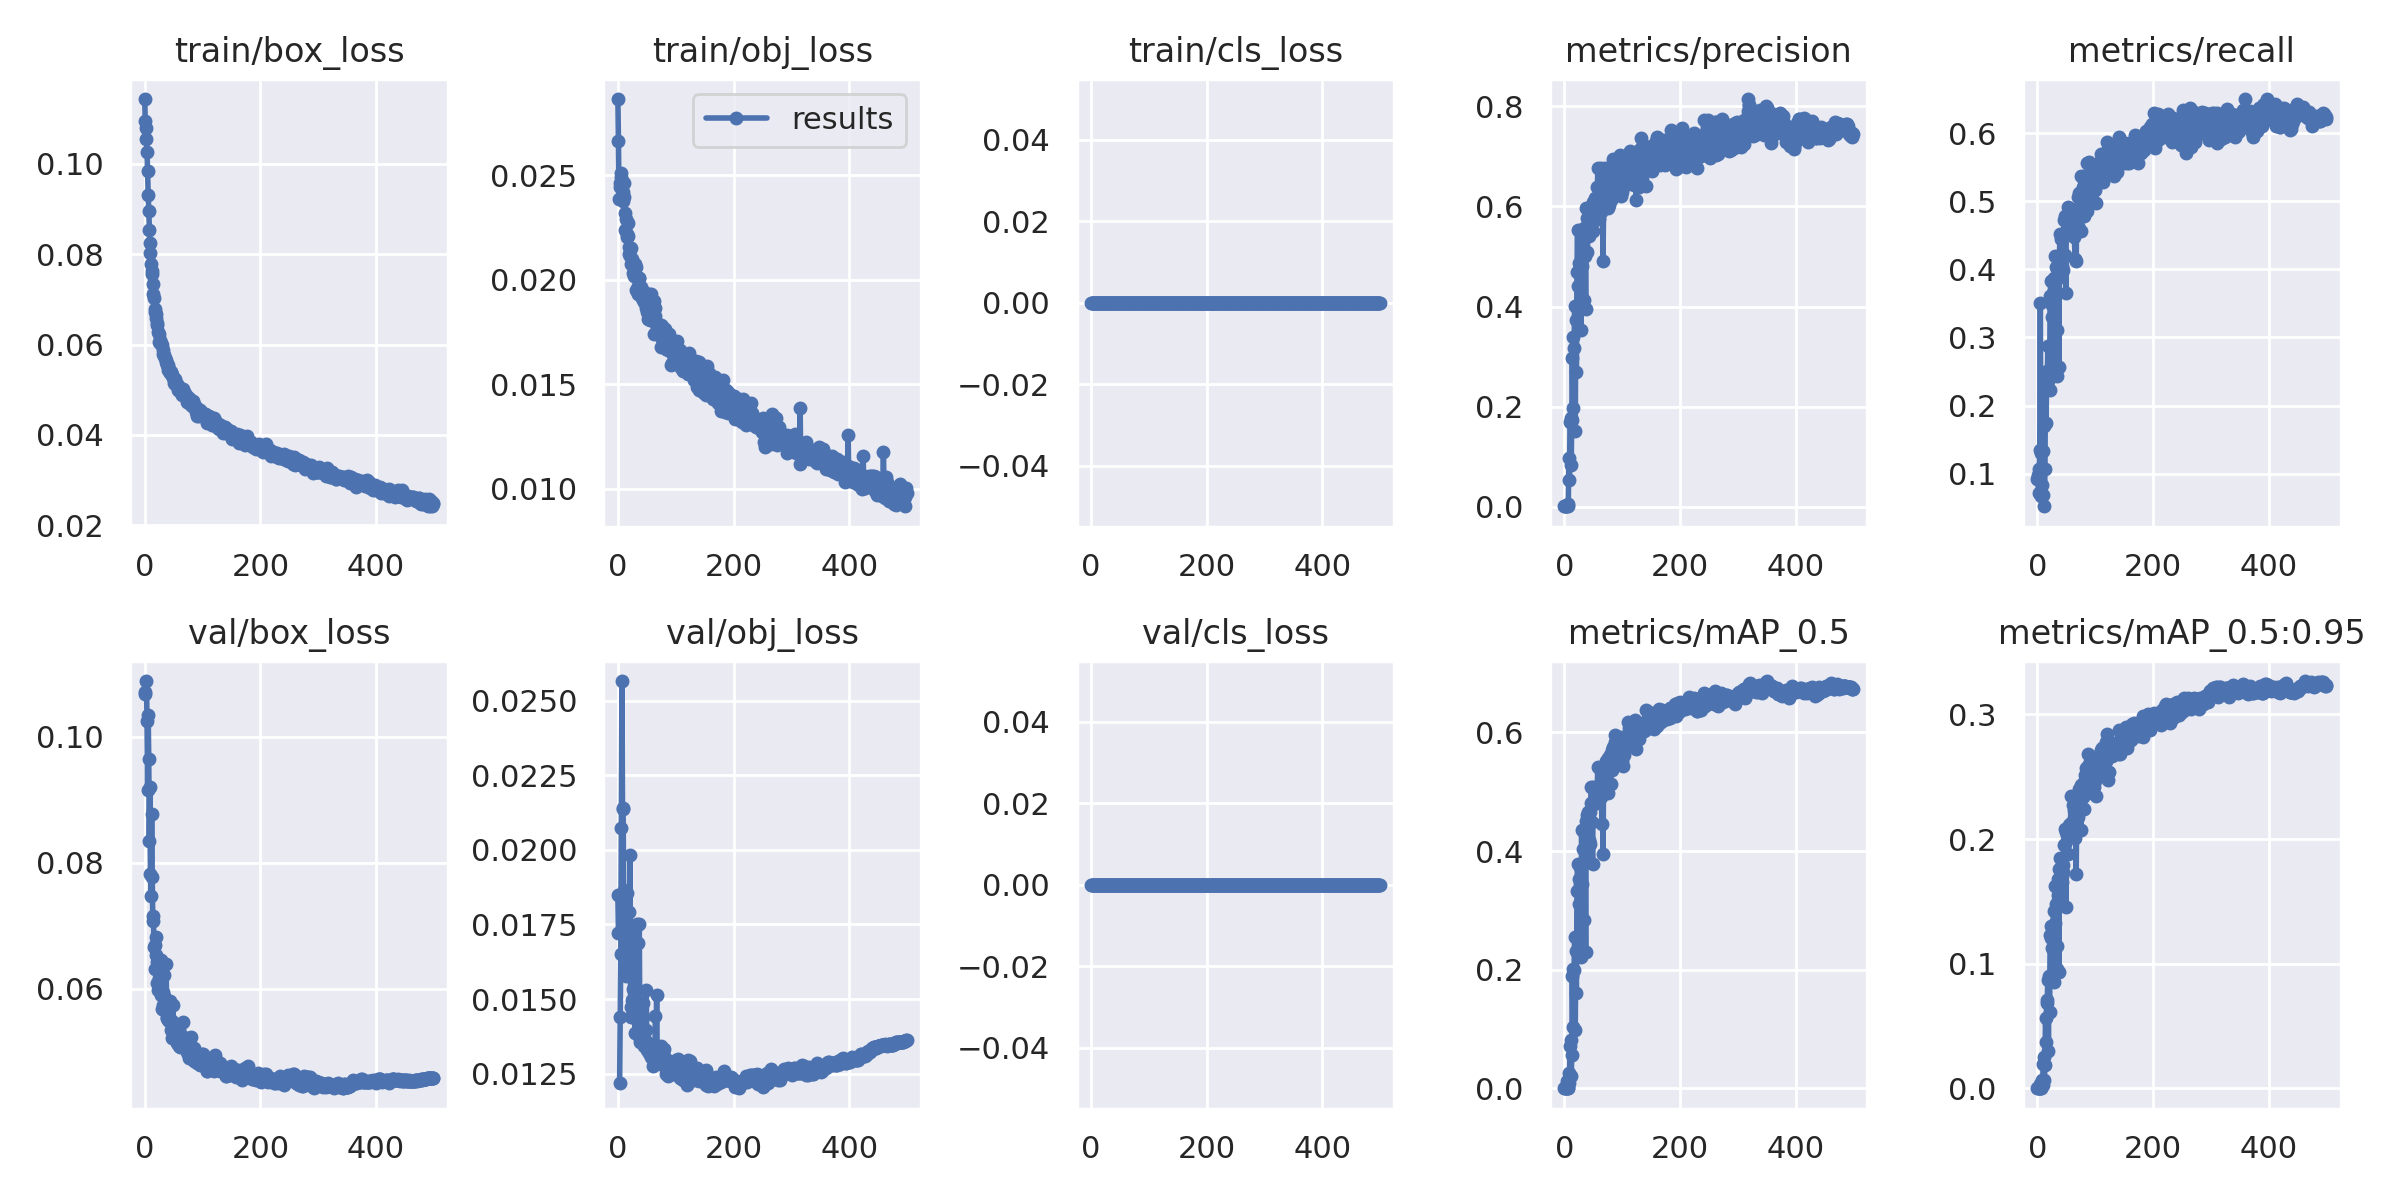

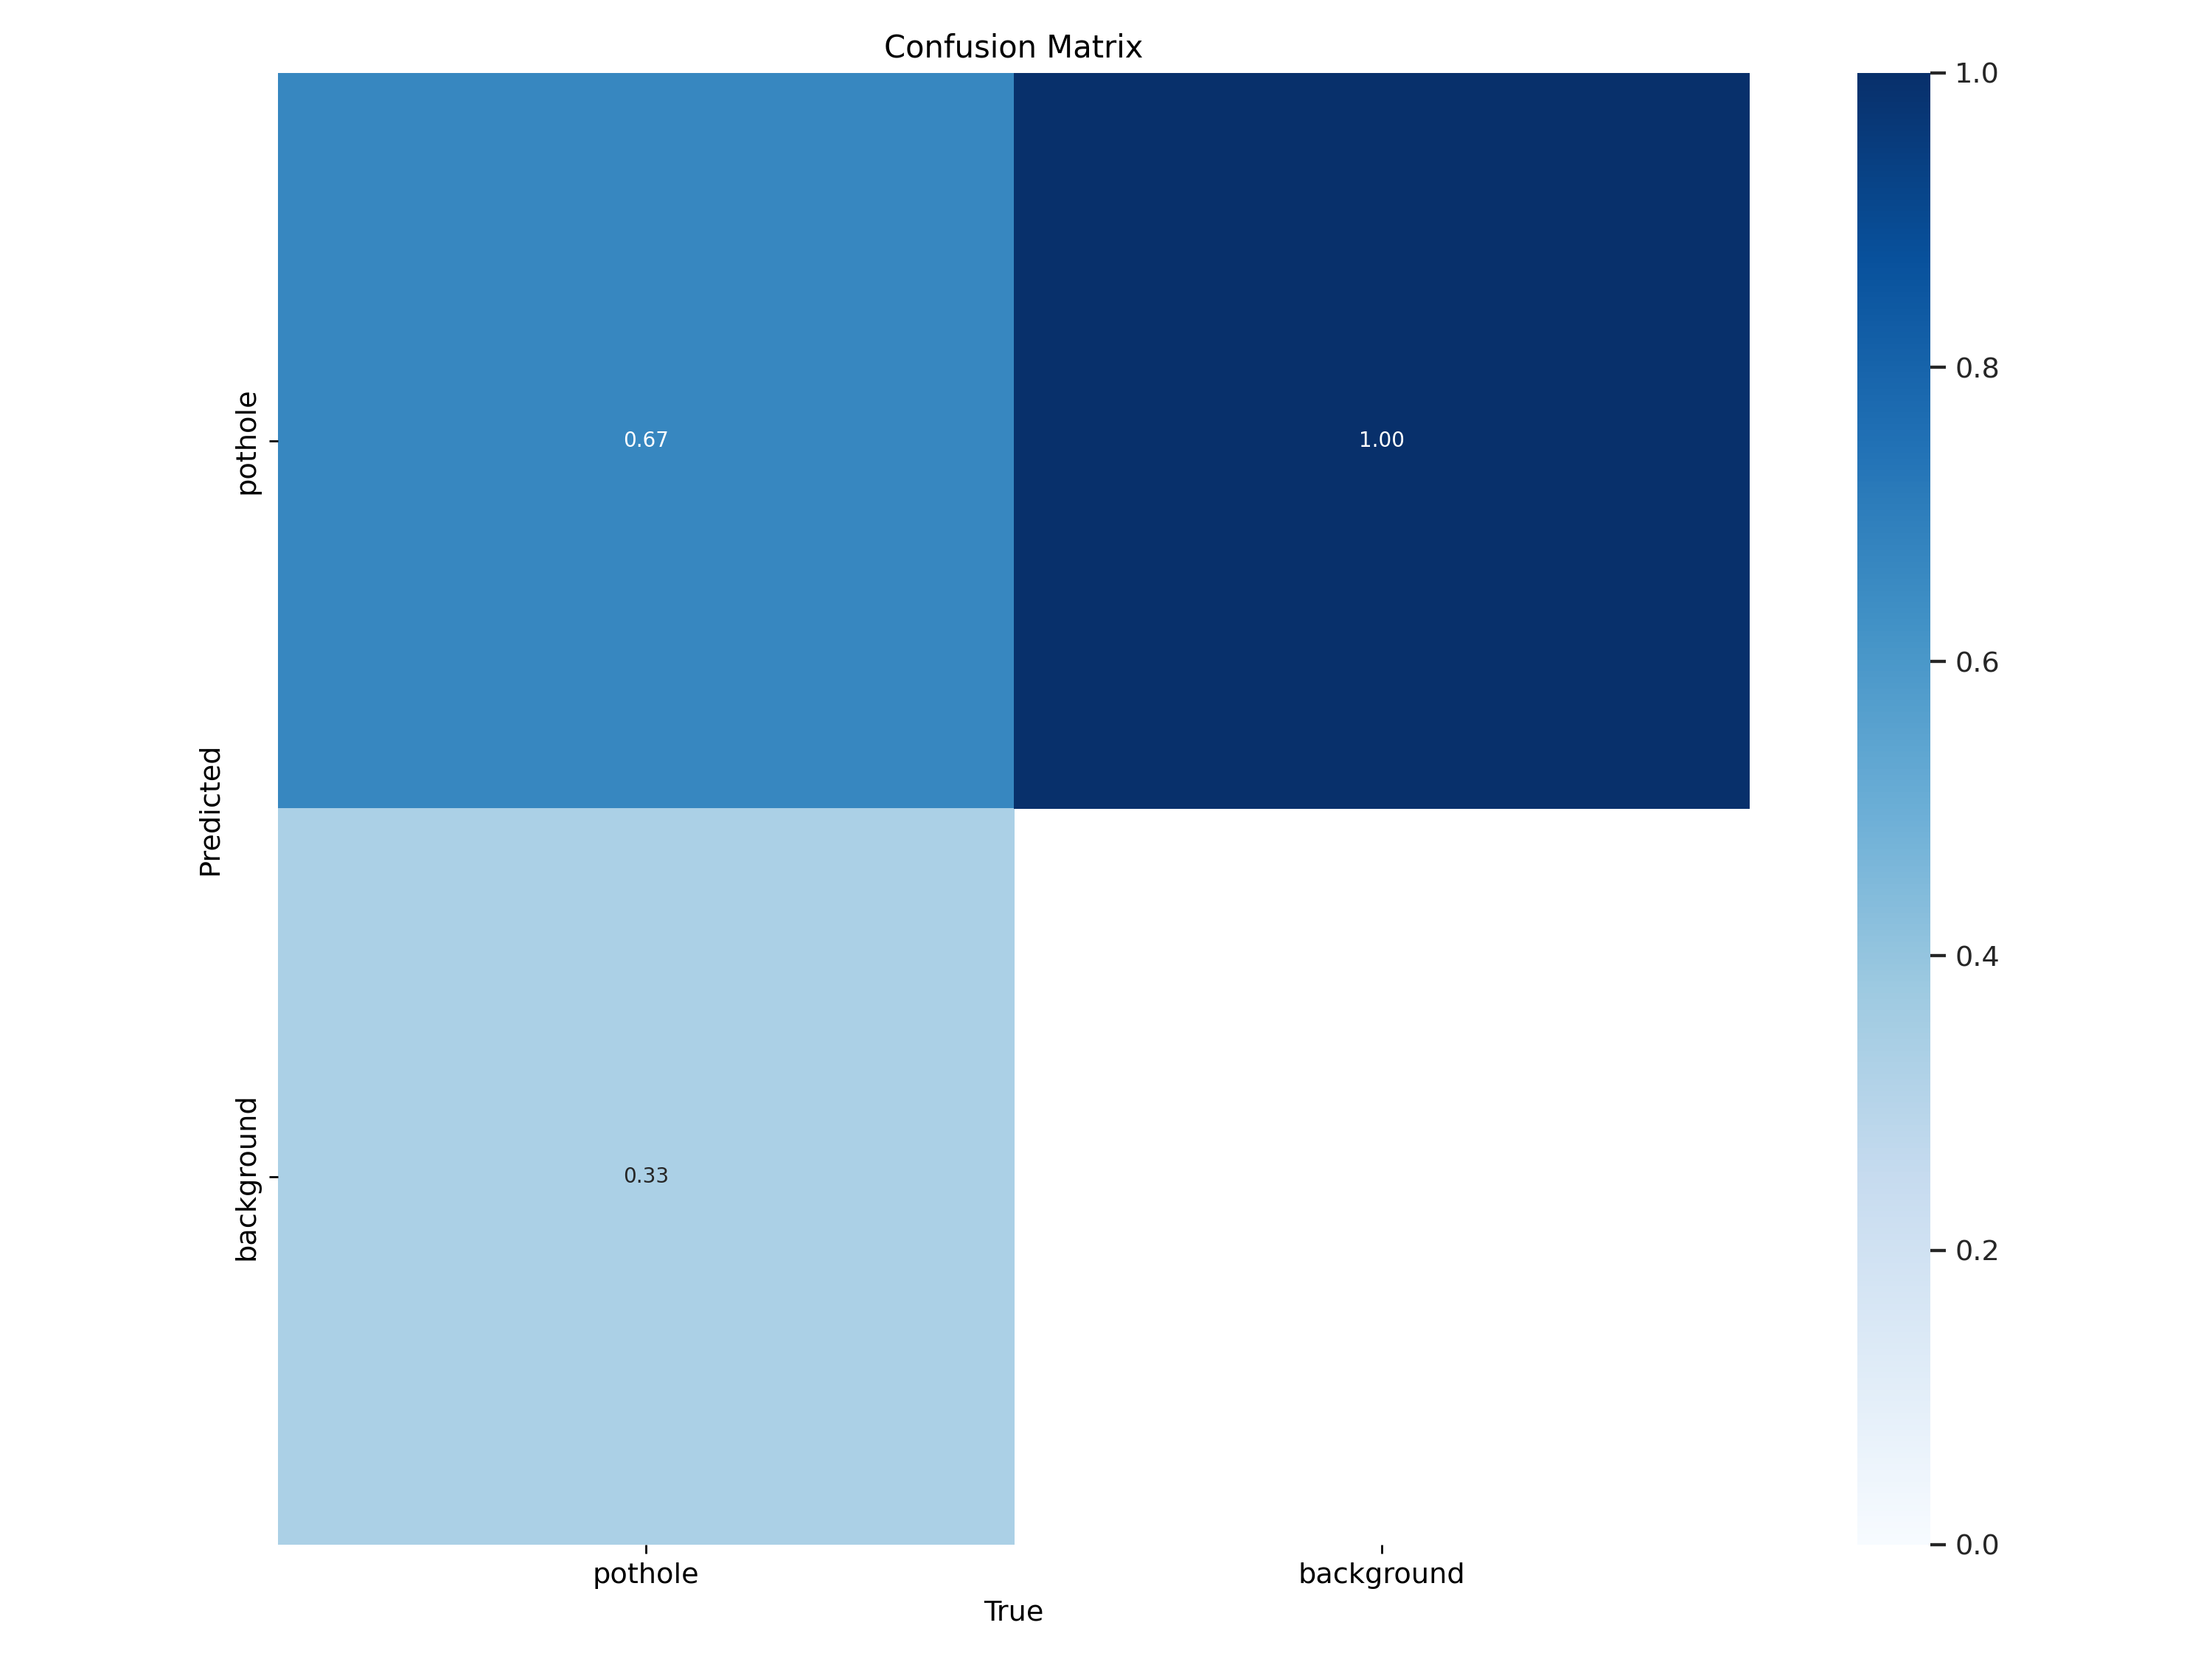

In [ ]:
# Training Plots

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/train/yolov5s_results/*.png'):
    display(Image(filename=imageName))
    print("\n")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy best.pt path from the output of the training step and use it below was the --weights argument
# In current case: /content/yolov5/runs/train/yolov5s_results2/weights/best.pt

!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source /content/drive/MyDrive/navyaji/potholesreal

detect: weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'], source=/content/drive/MyDrive/navyaji/potholesreal, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-107-g7a972e8 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7246518 parameters, 0 gradients
image 1/15 /content/drive/MyDrive/navyaji/potholesreal/IMG-20230219-WA0011.jpg: 416x352 (no detections), 18.9ms
image 2/15 /content/drive/MyDrive/navyaji/potholesreal/IMG-20230219-WA0012.jpg: 288x416 1 pothole, 18.3ms
image 3/15 /content/drive/MyDrive/navyaji/potholesreal/IMG-20230219-

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'):
    display(Image(filename=imageName))
    print("\n")

In [ ]:
!python val.py --data '/content/custom_dataset/pothole_dataset/images/data.yaml' --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt

In [ ]:
# Plots

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/val/exp2/*.png'):
    display(Image(filename=imageName))
    print("\n")